### Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U colabcode
import colabcode
colabcode.ColabCode(
    port=12000,
    authtoken='21eNVw6XbU2fjExgUWxa47wNx8x_6AfyfxMFYUmSWFLxW7b72',
    lab=True
)

Mounted at /content/drive
     |████████████████████████████████| 8.3 MB 5.5 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 745 kB 37.7 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 428 kB 35.4 MB/s 
     |████████████████████████████████| 396 kB 34.1 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 129 kB 60.2 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 125 kB 65.4 MB/s 
     |████████████████████████████████| 124 kB 75.2 MB/s 
     |████████████████████████████████| 124 kB 74.0 MB/s 
     |████████████████████████████████| 122 kB 61.1 MB/s 
     |████████████████████████████████| 122 kB 61.6 MB/s 
     |████████████████████████████████| 122 kB 61.3 MB/s 
     |████████████████████████████████| 122 kB 57.5 MB/s 

In [1]:
!gdown --id 1A-59GMNuJWbrbCc17zvBPkOycSdCBdCA

Downloading...
From: https://drive.google.com/uc?id=1A-59GMNuJWbrbCc17zvBPkOycSdCBdCA
To: /content/vacancies_lemmatized.csv
100% 902M/902M [00:05<00:00, 152MB/s]


In [110]:
import pandas as pd
df = pd.read_csv('vacancies_lemmatized.csv')
df = df[df['language'] == 'ru']

### Лемматизация

In [ ]:
!gdown --id 1YsX2nb2IxiKICa7S1b5LLMNC0puVwwry

In [ ]:
df = pd.read_csv('vacancies_processed.csv')

In [ ]:
# !pip install pymorphy2
import pymorphy2
import re
morph = pymorphy2.MorphAnalyzer()
def lemmatize(text):
  """
  Создаём метод, который лемматизирует текст.
  Аргумент:
  text - текст, который нужно лемматизировать
  Возвращает:
  res - лемматизированный текст
  """
  try:
      words = re.split(r'\W+', text) # разбиваем текст на слова
  except:
    return text
  res = str()
  for word in words:
      p = morph.parse(word)[0]
      res += (p.normal_form) + ' '
  return res

In [ ]:
columns_for_lem = ['raw_description', 'description', 'description_responsibilities', 'description_requirements', 'description_conditions']
lemmatized_columns = ['lem_raw_desc', 'lem_desc', 'lem_desc_resp', 'lem_desc_req', 'lem_desc_con']
for j in range(len(columns_for_lem)):
  df[lemmatized_columns[j]] = 0
  df[lemmatized_columns[j]][df['language'] == 'ru'] = df[columns_for_lem[j]][df['language'] == 'ru'].apply(lemmatize)

In [ ]:
df.to_csv('vacancies_lemmatized.csv', index=False)

### Модели

In [2]:
# классифицируем prof_area, фичи - tfidf над столбцом lem_raw_desc (max_features=4000)
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
import joblib
from sklearn.linear_model import LogisticRegression

In [5]:
df = df[['lem_raw_desc', 'specialization', 'specializations_name']][df['language'] == 'ru'].dropna()

In [ ]:
def fill_prof_area(prof_areas, row:  list):
  """
  Создаём метод, который заполняет словарь prof_area сферами и частотой их встречания в вакансиях
  Аргумент:
  row - строка в датафрейме
  """
  for el in row:
    if el in prof_areas:
      prof_areas[el] += 1
    else:
      prof_areas[el] = 1

def decrease_specializations(x: str):
  """
  Создаём метод, которые вместо наименее популярных специализаций пишет "Другое"
  Аргумент:
  х - специализация
  Возвращает:
  х - специализация
  """
  try:
    if specializations[x]/len(df) < 0.01:
      return 'Другое'
    else:
      return x
  except:
    return x

specializations = dict()
df['specializations_name'].apply(lambda x: fill_prof_area(specializations, eval(x)));

In [ ]:
df['specialization'] = df['specialization'].apply(decrease_specializations)

In [111]:
X = df[['len_description_responsibilities', 'len_description_requirements', 'len_description_conditions', 'lem_raw_desc', 'prof_area']]
X_train, X_test, y_train, y_test = train_test_split(X[['len_description_responsibilities', 'len_description_requirements', 'len_description_conditions', 'lem_raw_desc']], X['prof_area'], test_size=0.2, random_state=42)

In [112]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words={'russian', 'english'}, max_features=14000)

# We transform each complaint into a vector

tfidf.fit(X_train['lem_raw_desc'])
features = tfidf.transform(X_train['lem_raw_desc'])

In [115]:
# Сохраняем tfidf.vocabulary_
import pickle
pickle.dump(tfidf.vocabulary_,open("lem_desc_tfidf_14000.pkl","wb"))

In [6]:
# Добавляем фичи с длинами массивов
feat = ['len_description_responsibilities', 'len_description_requirements', 'len_description_conditions']
features = pd.DataFrame(features.toarray())
for feature in feat:
  features[feature] = X_train[feature]
  features[feature]= features[feature].fillna(features[feature].mode().values[0])
features = features.to_numpy()

In [ ]:
for col in X_train.columns:
  if col != 'description':
    features = pd.concat([features,
                          pd.DataFrame(tfidf.fit_transform(X_train[col].values.astype('U')).toarray())], axis=1)

In [12]:
del X_train

In [116]:
model = LogisticRegression()
model.fit(features, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [13]:
del features

In [95]:
# Загружаем модель
model = joblib.load("lem_desc_tfidf_LR_prof_area_7000.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'lem_desc_tfidf_LR_prof_area_7000.pkl'

In [117]:
features_test = tfidf.transform(X_test['lem_raw_desc'])

In [11]:
# Добавляем фичи с длинами массивов
feat = ['len_description_responsibilities', 'len_description_requirements', 'len_description_conditions']
features_test = pd.DataFrame(features_test.toarray())
for feature in feat:
  features_test[feature] = X_test[feature]
  features_test[feature]= features_test[feature].fillna(features_test[feature].mode().values[0])
features_test = features_test.to_numpy()

In [ ]:
for col in X_test.columns:
  if col != 'description':
    features_test = pd.concat([features_test,
                          pd.DataFrame(tfidf.transform(X_test[col].values.astype('U')).toarray())], axis=1)

In [118]:
y_pred = model.predict(features_test)

In [119]:
# Сохраняем модель
joblib.dump(model, 'lem_desc_tfidf_LR_prof_area_14000.pkl', compress=8)

['lem_desc_tfidf_LR_prof_area_14000.pkl']

In [17]:
df['salary_currency'].value_counts()

RUR    74246
BYR     6937
KZT     6001
UZS      691
UAH      517
USD      481
KGS      178
EUR      122
AZN       33
GEL        4
Name: salary_currency, dtype: int64

In [80]:
# Переводим з/п в рубли по курсу на 09.12.2021
currency = {'RUR': 1, 'BYR': 29.04, 'KZT': 0.17, 'UZS': 0.0068, 'UAH': 2.72, 'USD': 73.66, 'KGS': 0.87, 'EUR': 83.32, 'AZN': 43.33, 'GEL': 23.73}

In [120]:
# Переводим з/п в нерублёвых валютах в рубли
for curr in df['salary_currency'].unique():
    df['salary_from'][df['salary_currency'] == curr] = df['salary_from'][df['salary_currency'] == curr].apply(lambda x: x*currency[curr])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
salary_groupped_prof_area = df[['prof_area', 'salary_from']].groupby(['prof_area']).mean()
salary_groupped_prof_area_std = df[['prof_area', 'salary_from']].groupby(['prof_area']).std()
salary_pred = salary_groupped_prof_area.loc[y_pred]
salary_test = df.loc[y_test.index, 'salary_from']

In [122]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
salary = pd.DataFrame()
salary['y_pred'] = y_pred
salary['test'] =  list(salary_test)
salary['pred'] = list(salary_pred['salary_from'])
salary['true_prof_area'] = list(df.loc[y_test.index, 'prof_area'])
salary = salary.dropna()
regression_report = []
for area in salary['true_prof_area'].unique():
  regression_report.append([round(mean_absolute_error(salary['pred'][salary['true_prof_area'] == area], salary['test'][salary['true_prof_area'] == area]), 1),
  round(float(salary_groupped_prof_area.loc[area]), 1), round(float(salary_groupped_prof_area_std.loc[area]), 1)])

# raw_desc_tfidf_RF_specialization

In [ ]:
report = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report.style.format(formatter='{:,.2f}').background_gradient()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
"FMCG, Товары народного потребления",0.83,0.52,0.64,393.00
Автоперевозки,0.63,0.54,0.59,563.00
Бухгалтер,0.74,0.53,0.61,527.00
Ввод данных,0.86,0.24,0.38,172.00
Водитель,0.68,0.46,0.55,411.00
Грузчик,0.62,0.58,0.60,433.00
Делопроизводство,0.88,0.12,0.21,250.00
Дистрибуция,0.86,0.35,0.50,51.00
Другое,0.59,0.94,0.73,"9,335.00"
Инженер,0.96,0.15,0.26,156.00


In [ ]:
report = pd.DataFrame(regression_report)
report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
report.index = salary['true_prof_area'].unique()
report.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
Управление проектами,"30,798.5","65,899.4","42,813.8"
Разнорабочий,"17,142.1","49,335.7","23,880.1"
Другое,"19,414.8","42,712.8","46,413.8"
Розничная торговля,"10,034.4","28,494.4","13,875.3"
Машиностроение,"35,999.9","57,643.3","88,093.0"
"Официант, Бармен","13,858.0","29,079.8","15,631.4"
Бухгалтер,"12,407.3","34,991.7","21,897.9"
"Начальный уровень, Мало опыта","14,556.8","31,931.8","16,461.8"
Кладовщик,"10,401.8","35,464.6","14,676.7"
Прямые продажи,"15,048.3","38,508.9","19,659.4"


# raw_desc_tfidf_RF_prof_area

In [68]:
report_raw = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report_raw.style.format(formatter='{:,.2f}').background_gradient()

,precision,recall,f1-score,support
Автомобильный бизнес,0.81,0.46,0.58,535.00
Административный персонал,0.56,0.54,0.55,"1,389.00"
"Банки, инвестиции, лизинг",0.89,0.81,0.85,767.00
Безопасность,0.85,0.60,0.70,420.00
"Бухгалтерия, управленческий учет, финансы предприятия",0.67,0.75,0.71,798.00
Высший менеджмент,0.79,0.19,0.31,137.00
"Государственная служба, некоммерческие организации",0.86,0.53,0.65,123.00
Добыча сырья,0.88,0.32,0.47,289.00
Домашний персонал,0.79,0.12,0.20,94.00
Закупки,0.86,0.20,0.33,157.00


In [69]:
regression_report_raw = pd.DataFrame(regression_report)
regression_report_raw.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
regression_report_raw.index = salary['true_prof_area'].unique()
regression_report_raw.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
"Туризм, гостиницы, рестораны","17,110.5","33,142.0","28,482.7"
"Медицина, фармацевтика","17,011.3","45,190.0","24,878.1"
"Строительство, недвижимость","26,963.7","62,604.0","40,365.7"
"Транспорт, логистика","20,733.7","50,415.2","31,810.0"
Добыча сырья,"39,371.7","93,275.2","45,668.6"
Продажи,"13,387.1","34,006.1","94,141.3"
"Банки, инвестиции, лизинг","14,260.5","41,680.5","21,450.6"
Административный персонал,"13,645.6","31,071.0","17,291.7"
"Информационные технологии, интернет, телеком","25,518.9","46,612.0","44,111.6"
"Маркетинг, реклама, PR","13,146.9","32,251.2","16,794.2"


# lem_desc_tfidf_RF_prof_area

In [48]:
report = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report.style.format(formatter='{:,.2f}').background_gradient()

,precision,recall,f1-score,support
Автомобильный бизнес,0.83,0.44,0.57,535.00
Административный персонал,0.56,0.53,0.55,"1,389.00"
"Банки, инвестиции, лизинг",0.89,0.81,0.85,767.00
Безопасность,0.88,0.63,0.74,420.00
"Бухгалтерия, управленческий учет, финансы предприятия",0.71,0.78,0.74,798.00
Высший менеджмент,0.79,0.19,0.31,137.00
"Государственная служба, некоммерческие организации",0.90,0.52,0.66,123.00
Добыча сырья,0.84,0.36,0.50,289.00
Домашний персонал,0.80,0.17,0.28,94.00
Закупки,0.85,0.21,0.34,157.00


In [84]:
regression_report_lem = pd.DataFrame(regression_report)
regression_report_lem.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
regression_report_lem.index = salary['true_prof_area'].unique()
regression_report_lem.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
"Туризм, гостиницы, рестораны","17,179.9","33,142.0","28,482.7"
"Медицина, фармацевтика","17,197.8","45,190.0","24,878.1"
"Строительство, недвижимость","26,813.0","62,604.0","40,365.7"
"Транспорт, логистика","20,732.4","50,415.2","31,810.0"
Добыча сырья,"40,210.4","93,275.2","45,668.6"
Продажи,"13,350.4","34,006.1","94,141.3"
"Банки, инвестиции, лизинг","14,209.8","41,680.5","21,450.6"
Административный персонал,"13,648.2","31,071.0","17,291.7"
"Информационные технологии, интернет, телеком","25,676.8","46,612.0","44,111.6"
"Маркетинг, реклама, PR","13,300.6","32,251.2","16,794.2"


# lem_desc_tfidf_RF_specialization

In [ ]:
report_lem = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report_lem.style.format(formatter='{:,.2f}').background_gradient()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
"FMCG, Товары народного потребления",0.82,0.50,0.62,393.00
Автоперевозки,0.61,0.53,0.57,563.00
Бухгалтер,0.73,0.57,0.64,527.00
Ввод данных,0.84,0.25,0.39,172.00
Водитель,0.66,0.42,0.52,411.00
Грузчик,0.64,0.60,0.62,433.00
Делопроизводство,0.90,0.11,0.19,250.00
Дистрибуция,0.82,0.35,0.49,51.00
Другое,0.60,0.94,0.73,"9,335.00"
Инженер,0.92,0.15,0.25,156.00


In [ ]:
report = pd.DataFrame(regression_report)
report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
report.index = salary['true_prof_area'].unique()
report.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
Управление проектами,"30,798.5","65,899.4","42,813.8"
Разнорабочий,"17,192.3","49,335.7","23,880.1"
Другое,"19,406.6","42,712.8","46,413.8"
Розничная торговля,"10,108.1","28,494.4","13,875.3"
Машиностроение,"36,139.6","57,643.3","88,093.0"
"Официант, Бармен","14,842.9","29,079.8","15,631.4"
Бухгалтер,"12,209.2","34,991.7","21,897.9"
"Начальный уровень, Мало опыта","14,729.7","31,931.8","16,461.8"
Кладовщик,"10,467.2","35,464.6","14,676.7"
Прямые продажи,"15,043.2","38,508.9","19,659.4"


# raw_desc_tfidf_LR_prof_area_with_len

In [18]:
report_lem = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report_lem.style.format(formatter='{:,.2f}').background_gradient()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Автомобильный бизнес,0.80,0.27,0.40,535.00
Административный персонал,0.39,0.57,0.46,"1,389.00"
"Банки, инвестиции, лизинг",0.72,0.71,0.72,767.00
Безопасность,0.82,0.32,0.46,420.00
"Бухгалтерия, управленческий учет, финансы предприятия",0.61,0.72,0.66,798.00
Высший менеджмент,1.00,0.01,0.03,137.00
"Государственная служба, некоммерческие организации",0.89,0.34,0.49,123.00
Добыча сырья,1.00,0.03,0.06,289.00
Домашний персонал,0.00,0.00,0.00,94.00
Закупки,0.56,0.03,0.06,157.00


In [21]:
report = pd.DataFrame(regression_report_lem)
report.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
report.index = salary['true_prof_area'].unique()
report.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
"Туризм, гостиницы, рестораны","17,043.3","33,142.0","28,482.7"
"Медицина, фармацевтика","16,943.9","45,190.0","24,878.1"
"Строительство, недвижимость","27,704.6","62,604.0","40,365.7"
"Транспорт, логистика","20,552.9","50,415.2","31,810.0"
Добыча сырья,"42,858.5","93,275.2","45,668.6"
Продажи,"13,260.4","34,006.1","94,141.3"
"Банки, инвестиции, лизинг","14,329.4","41,680.5","21,450.6"
Административный персонал,"13,589.2","31,071.0","17,291.7"
"Информационные технологии, интернет, телеком","24,855.0","46,612.0","44,111.6"
"Маркетинг, реклама, PR","13,390.8","32,251.2","16,794.2"


# lem_desc_tfidf_LR_prof_area_7000

In [123]:
report_lem_LR = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T
report_lem_LR.style.format(formatter='{:,.2f}').background_gradient()

,precision,recall,f1-score,support
Автомобильный бизнес,0.77,0.49,0.60,535.00
Административный персонал,0.55,0.63,0.59,"1,389.00"
"Банки, инвестиции, лизинг",0.87,0.82,0.85,767.00
Безопасность,0.84,0.72,0.78,420.00
"Бухгалтерия, управленческий учет, финансы предприятия",0.81,0.79,0.80,798.00
Высший менеджмент,0.65,0.23,0.34,137.00
"Государственная служба, некоммерческие организации",0.80,0.53,0.64,123.00
Добыча сырья,0.77,0.46,0.58,289.00
Домашний персонал,0.77,0.29,0.42,94.00
Закупки,0.63,0.36,0.46,157.00


In [124]:
regression_report_lem_LR = pd.DataFrame(regression_report)
regression_report_lem_LR.columns = ['MAE', 'salary_from_mean', 'salary_from_std']
regression_report_lem_LR.index = salary['true_prof_area'].unique()
regression_report_lem_LR.style.format(formatter='{:,.1f}').background_gradient()

,MAE,salary_from_mean,salary_from_std
"Туризм, гостиницы, рестораны","16,603.1","33,142.0","28,482.7"
"Медицина, фармацевтика","16,936.5","45,190.0","24,878.1"
"Строительство, недвижимость","27,416.9","62,604.0","40,365.7"
"Транспорт, логистика","20,797.7","50,415.2","31,810.0"
Добыча сырья,"37,627.8","93,275.2","45,668.6"
Продажи,"13,240.2","34,006.1","94,141.3"
"Банки, инвестиции, лизинг","14,222.7","41,680.5","21,450.6"
Административный персонал,"13,244.1","31,071.0","17,291.7"
"Информационные технологии, интернет, телеком","25,125.8","46,612.0","44,111.6"
"Маркетинг, реклама, PR","12,112.9","32,251.2","16,794.2"


# Сравнение моделей

In [51]:
import matplotlib
import seaborn as sns
from matplotlib import pyplot
matplotlib.rcParams['figure.figsize'] = (18, 4)

## specialization

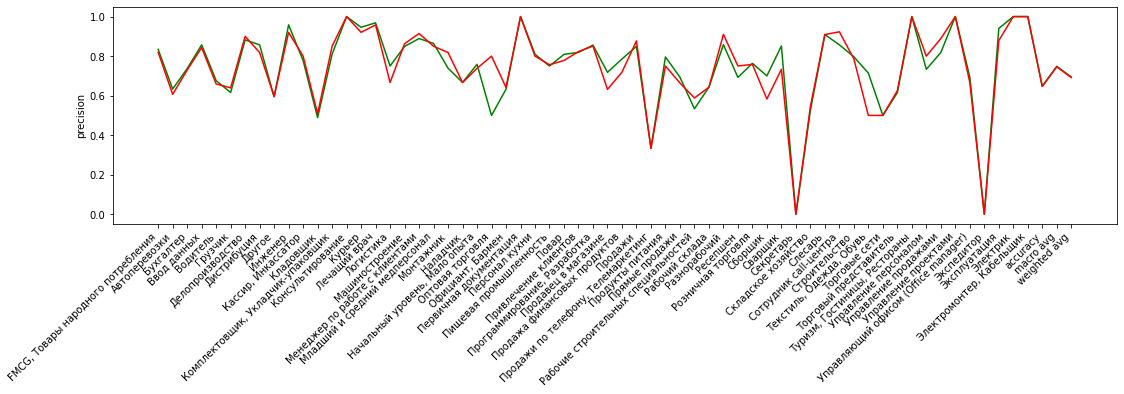

In [ ]:
sns.lineplot(x=report.index, y=report['precision'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_lem.index, y=report_lem['precision'], color='red')

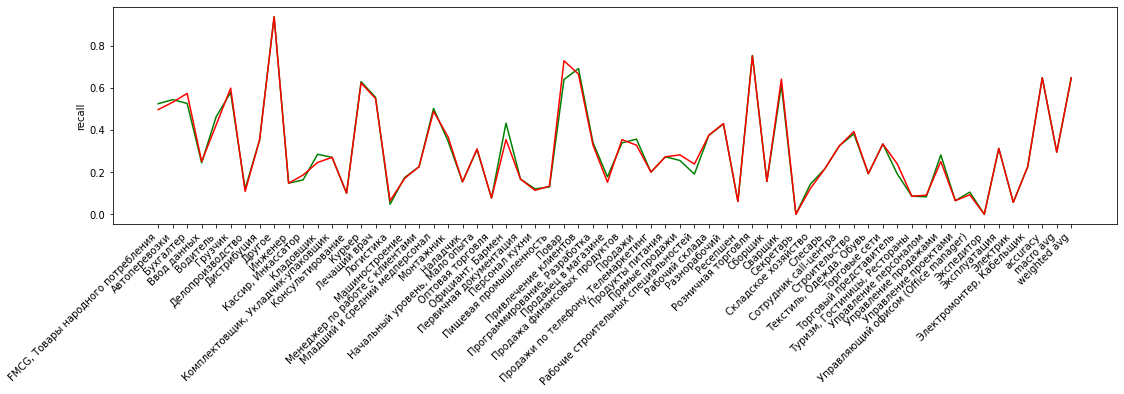

In [ ]:
sns.lineplot(x=report.index, y=report['recall'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_lem.index, y=report_lem['recall'], color='red')

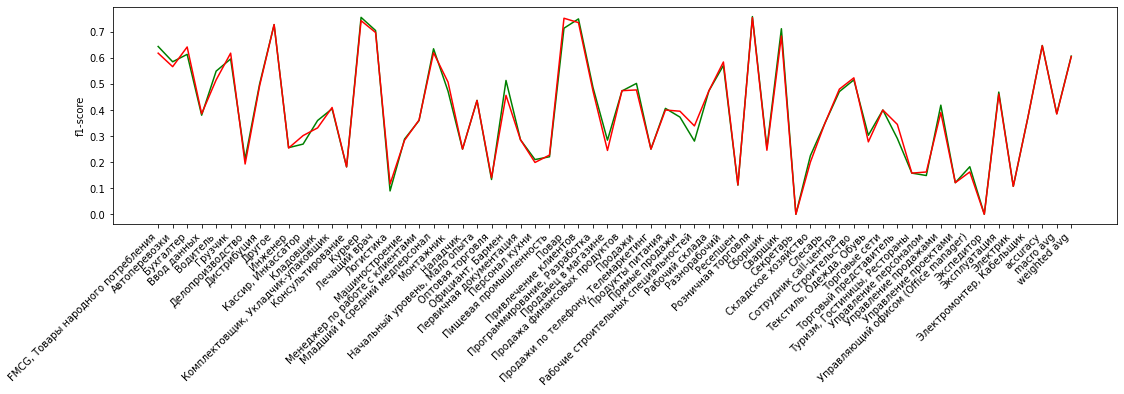

In [ ]:
sns.lineplot(x=report.index, y=report['f1-score'], color='green')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_lem.index, y=report_lem['f1-score'], color='red')

# prof_area

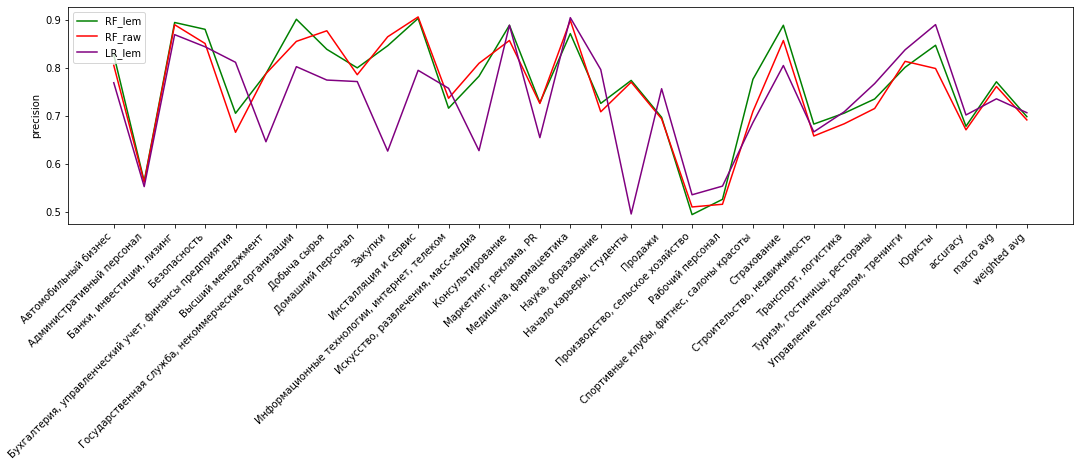

In [127]:
sns.lineplot(x=report.index, y=report['precision'], color='green', label='RF_lem')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_raw.index, y=report_raw['precision'], color='red', label='RF_raw')
sns.lineplot(x=report_lem_LR.index, y=report_lem_LR['precision'], color='purple', label='LR_lem')

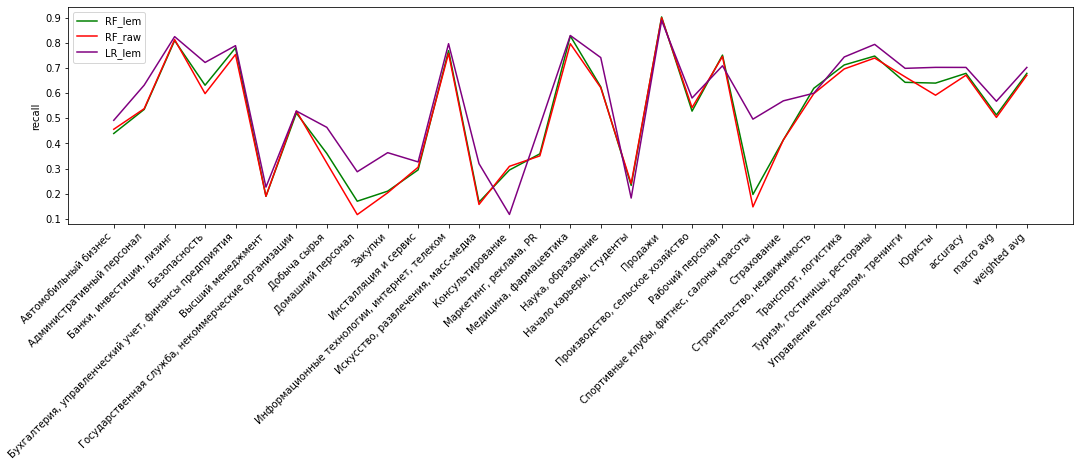

In [128]:
sns.lineplot(x=report.index, y=report['recall'], color='green', label='RF_lem')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_raw.index, y=report_raw['recall'], color='red', label='RF_raw')
sns.lineplot(x=report_lem_LR.index, y=report_lem_LR['recall'], color='purple', label='LR_lem')

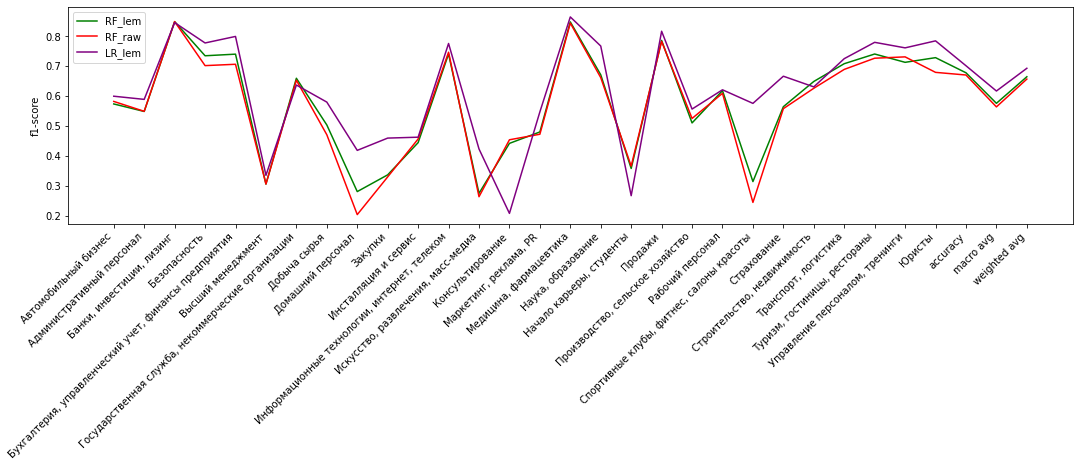

In [129]:
sns.lineplot(x=report.index, y=report['f1-score'], color='green', label='RF_lem')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=report_raw.index, y=report_raw['f1-score'], color='red', label='RF_raw')
sns.lineplot(x=report_lem_LR.index, y=report_lem_LR['f1-score'], color='purple', label='LR_lem')

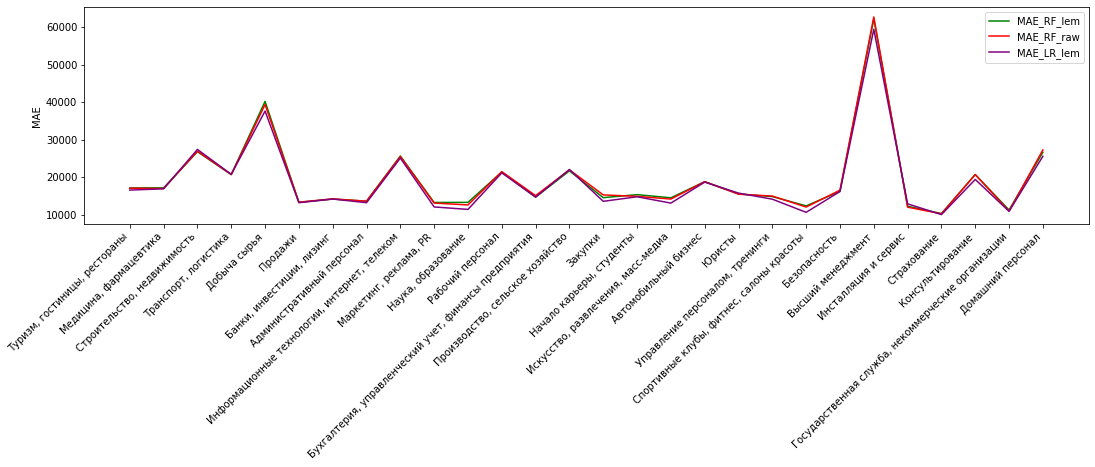

In [134]:
sns.lineplot(x=regression_report_lem.index, y=regression_report_lem['MAE'], color='green', label='MAE_RF_lem')
sns.lineplot(x=regression_report_raw.index, y=regression_report_raw['MAE'], color='red', label='MAE_RF_raw')
sns.lineplot(x=regression_report_lem_LR.index, y=regression_report_lem_LR['MAE'], color='purple', label='MAE_LR_lem')
pyplot.xticks(rotation=45, ha="right");

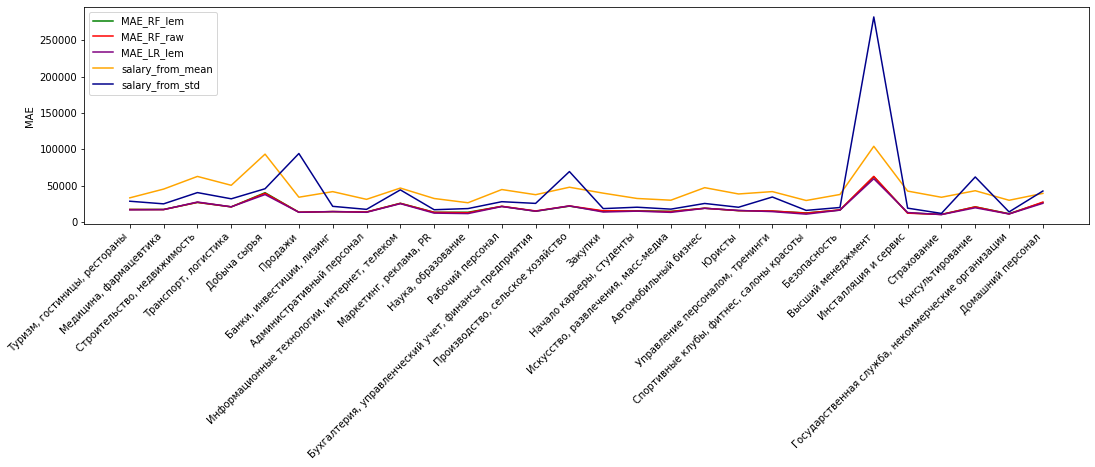

In [133]:
sns.lineplot(x=regression_report_lem.index, y=regression_report_lem['MAE'], color='green', label='MAE_RF_lem')
sns.lineplot(x=regression_report_raw.index, y=regression_report_raw['MAE'], color='red', label='MAE_RF_raw')
sns.lineplot(x=regression_report_lem_LR.index, y=regression_report_lem_LR['MAE'], color='purple', label='MAE_LR_lem')
pyplot.xticks(rotation=45, ha="right");
sns.lineplot(x=regression_report_raw.index, y=regression_report_raw['salary_from_mean'], color='orange', label='salary_from_mean')
sns.lineplot(x=regression_report_raw.index, y=regression_report_raw['salary_from_std'], color='darkblue', label='salary_from_std')